# SIT744 Assignment 1: Image Classification with Deep Feedforward Neural Network



<div class="alert-info">
    <p><strong>Name:</strong> Linh Tran</p>
    <p><strong>ID: </strong>218609476</p>

<p>
    <strong>
It is highly recommended that maker refer to the pdf attached with the submission for detailed report and pictures please!
</strong>
</p>
</div>

## Assignment objective



This assignment is for you to demonstrate the knowledge in deep learning that you have acquired from the lectures and practical lab materials. Most tasks in this assignment are straightforward applications of the practical materials in weeks 1-5. Going through these materials before attempting this assignment is highly recommended.

In this assignment, you are going to work with the Fashion-MNIST dataset for image recognition. The dataset contains 10 classes of 28x28 grayscale images. You will see some examples in the visualization task below. 

This assignment consists of five tasks.


## Task 1 Load the data

*(weight ~5%)*

Load the Fashion MNIST dataset (https://github.com/zalandoresearch/fashion-mnist). You may get the data via Keras (keras.datasets) or Tensorflow Datasets (tfds). 

#### Answer

In [1]:
%tensorflow_version 2.x
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.regularizers import l1, l2

# Helper libraries
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Task 2 Understand the data

*(weight ~15%)*



Display 100 images from the train set in the form of 10x10 matrix.

Answer the following questions:

1. What are the unique labels in this dataset?
2. How many training images and how many test images?
3. What is the size of each image?
4. Find out the numeric range of the input. Do we need to rescale the input?
5. In our problem, what are the shapes of input tensors and target tensors? Do you need to reshape the input?


#### Answer

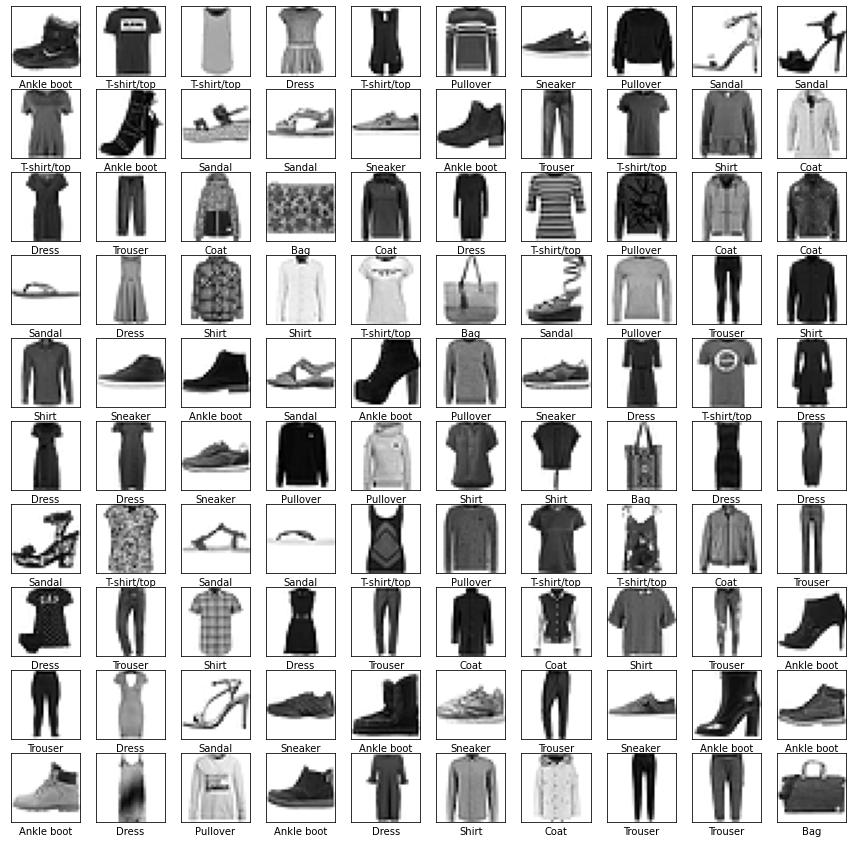

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [0]:
#2.1
unique_labels = np.unique(train_labels)
print("The unique labels in the dataset is:", unique_labels)

The unique labels in the dataset is: [0 1 2 3 4 5 6 7 8 9]


In [0]:
#2.2
print("The number of train images is:", len(train_images))
print("The number of test images is:", len(test_images))

The number of train images is: 60000
The number of test images is: 10000


In [0]:
#2.3
print("The size of an image is:", train_images[0].shape)

The size of an image is: (28, 28)


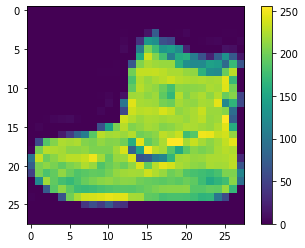

In [0]:
#2.4
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

The numeric range of the input falls between 0 and 255. Before feeding them into the NN we will have to rescale these values to a range of 0 to 1 by dividing them by 255. Both training and test sets are scaled in the same format.

In [0]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

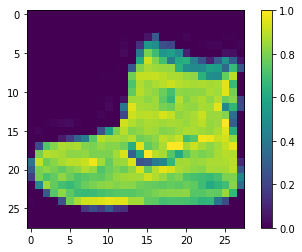

In [0]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [0]:
#2.5
print("The shape of an input tensor is:", train_images[0].shape)
print("The shape of a target tensor is:", train_labels[0].shape)

The shape of an input tensor is: (28, 28)
The shape of a target tensor is: ()


In our problem, the shape of input tensors is 2 dimensional (28 by 28 pixels). We should unstack rows of pixels in each image and line them up so that the shape of each input tensor becomes one dimensional representing a data record. Meanwhile, the shape of a target tensor is a scalar (no dimension) in the range between 0 and 9.

In [0]:
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))

In [0]:
print("The shape of an input tensor after reshape is:", train_images[0].shape)

The shape of an input tensor is: (784,)
The shape of a target tensor is: ()


## Task 3 Construct an input pipeline

*(weight ~15%)*

Creat train/validate/test data splits and construct tf.data pipelines. Make sure that the training data is batched.


#### Answer

In [2]:
#reload the dataset into train and test
train, test = tf.keras.datasets.fashion_mnist.load_data()

#split train, validation sets
x, y = train
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

x_train = x_train.reshape(len(x_train), 28 * 28).astype('float32')/255
y_train = to_categorical(y_train)

x_valid = x_valid.reshape(len(x_valid), 28 * 28).astype('float32')/255
y_valid = to_categorical(y_valid)

#process test set
x_test, y_test = test
x_test = x_test.reshape(10000, 28 * 28).astype('float32')/255

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
valid_batches = valid_set.batch(batch_size)
test_batches = test_set.batch(batch_size)

4423680/4422102 [==============================] - 0s 0us/step


## Task 4 Construct a deep forward neural network

*(weight ~35%)*

### Task 4.1 Setting up a model for training

Construct a deep feedforward neural network. You need to decide and report the following configurations:

- Output layer: 
    - How many output nodes?
    - Which activation function?
- Hidden layers:
    - How many hidden layers?
    - How many nodes in each layer?
    - Which activation function for each layer?
- Input layer
    - What is the input size?
- The loss function
- The metrics for model evaluation (which may be different from the loss function)
- The optimiser

Justify your model design decisions.

Plot the model structure `using keras.utils.plot_model` or similar tools.

#### Answer

- Input layer: the input shape is (28*28,)

- Output layer: the number of output nodes is 10 corresponding to 10 classes; as this is a categorical classification problem, I used ‘softmax’ activation function so that it converts outputs from the model into probabilities, between 0 and 1, making sure 10 elements in each output vector sum up to 1.

- Loss function: I used categorical cross-entropy to be the loss function, as the output from the model is probabilities already, I put ‘from_logits=False’.

- Metrics: other than loss function, I used categorical accuracy for evaluation.

- Hidden layers: I used fully connected Dense for intermediate layers, with activation function ‘relu’, a popular activation function recently which overcomes vanishing gradient problem and allows model to be trained faster with better performance (Brownie 2019); pairing with ‘relu’ activation, Kaiming initializer is a weight initialisation scheme that enables a neural network to sustain convergence over deep layers (Dellinger 2019).

- With hidden layers and optimiser settings, I carried out several experiments to test different configurations with  different number of hidden layers, nodes and optimisers to select a potential model. Each configuration initially trains the dataset over 20 epochs with batch size of 32.

- Below are all the configurations that I tested:

In [0]:
# Get the model
#test number of layers:
#1 layer:
# #config 1:
# model = models.Sequential()
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD()

# #config 2:
# model = models.Sequential()
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD()

# #config 3:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD()

# #config 4:
# model = models.Sequential()
# model.add(layers.Dense(512, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD()

# #2 layers:
# #config 5:
# model = models.Sequential()
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD()

# #config 6:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD()

# #3 layers:
# #config 7:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD()

# #test optimisers:
# #config 8:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.Adam()

# #config 9:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.Adagrad()

# #config 10:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.RMSprop()

# #test momentum and learning rate schedule
# #config 11:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=False)

# #config 12:
# #batch the sets according to batch_size
# batch_size = 32
# train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
# valid_batches = valid_set.batch(batch_size)
# test_batches = test_set.batch(batch_size)
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

#config 13 (baseline):
#batch the sets according to batch_size
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
model.add(layers.Dense(10, activation='softmax'))
# Instantiate an optimizer
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

Test number of hidden layers:
- 1 layer: I tested models with only one layer having 64, 128, 256 and 512 nodes respectively, when I compared the training loss and accuracy, it is clearly that layers with more nodes are better settings for the dataset training as they give higher accuracy and lower loss; (also, the validation loss and accuracy of models with more-nodes-layers is better); however, I rather selected 256 node layer (config 3) since 512nodes for a hidden layer (config4) is too large compared to 784 nodes from the input layer, which might cause overfitting if implemented further.
- 2 layers: I tested two models, one with 128 - 64 and the other with 256 - 128 nodes in hidden layers respectively. Results indicate models with 2 layers are better settings than those of 1 layer in terms of both optimization and generalization, meaning better than the previously selected config 3. To this point, model with 2 hidden layers 256 - 128 nodes (config 6) is the best model so far.
- 3 layers: I tried one more combination which is the model of 3 hidden layers 256-128-64 nodes. Again, the results kept improve, in terms of both train and validation metrics. Therefore, I switched to this one, config 7.

Test optimisers: I also tested with other optimisers than SGD, results show that SGD is still a better version of optimiser to the dataset as with Adam and RMSprop optimisers, it’s clearly that the training is getting overfitted too early, meaning worse generalization while with Adagrad, the training speed is too slow, meaning worse optimization. Hence, I still stick with config 7.

Test momentum and learning rate decay: With config 7, I added momentum and learning rate decay and see whether there was any impact. For momentum, I used the most frequently used value 0.9 (Ruder 2016) along with learning rate decay equal to 1e-03. I also tested the impact of Nesterov accelerated gradient in helping momentum to ‘foresee’ gradient direction (Ruder 2016). It turned out that ‘nesterov=True’ (config 12) was a good setting as it was able to lead to better model performance (even though just a bit) compared to ’nesterov=False’ setting. For learning rate, after testing with decay rate of 1e-3 (config12), I decrease decay rate down to 2e-06 (config 13) to see whether there was any more impact (a smaller decay rate will make a less sloppy learning rate decay schedule according to its formula (Rosebrock 2019) meaning learning rate is more slowly decayed). Results are that, when looking at training and validation loss and accuracy, it seems that config 12 is a better choice; however, when we look at the gradient norm graphs, it’s clearly that config 13 is more likely to lead training to convergence than config 12 as its gradient norm is going toward zero while that is config 12 is increasing. Hence, I’d go with config 13 into next tasks.

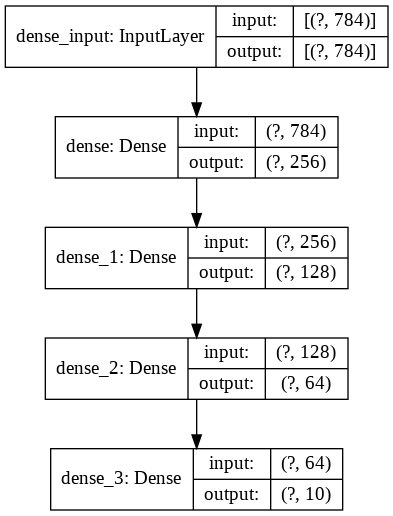

In [0]:
keras.utils.plot_model(model, show_shapes=True)

### Task 4.2 Fitting the model

Now fit the model. Decide and report the following training setting:

1. The training batch size
2. The number of training epochs (at least 1,000 epochs recommended)
3. The learning rate. If you used momentum or a learning rate schedule, please report the configuration as well.

Plot the training and validation loss and accuracy. Answer the following questions:

1. Do you see overfitting or underfitting? Why?
2. If you see overfitting, at which epoch did it happen?

#### Answer

- Before training, as tensorflow 2.0 has no option to display gradient histograms in Keras callback, I customized a training loop in order to do so. I set up the model according to the settings in the previous part and used GradientTape to calculate the gradients and tf.norm to calculate the gradient norms.
- After that I customized a training loop to iterate through the train and validation set.
- Before fitting the model for more epochs, I compared the impact of bigger batch sizes to the training performance. I tested with bigger batch sizes, the trials were also for 20 epochs. According to the table below, with batch size of 64 the training and validation loss is the lowest while accuracy is fair enough, I will fit the model with batch size 64 for 200 epochs:

|Metrics|32|64|128|
|---|---|---|---|
|train loss|0.259|0.259|0.283|
|train acc|92.506|92.476|91.406|
|valid loss|0.352|0.349|0.353|
|valid acc|87.988|87.893|87.815|
|test acc|90.415|91.720|92.405|

- Just after around 20 epochs, the model becomes overfitted as training accuracy keeps rising whereas validation accuracy becomes stagnant and training loss is still decreasing while validation loss is increasing. This means that model has good optimization but does not generalize well.

In [0]:
# Instantiate a loss function
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)
# Prepare the metrics
train_acc_metric = keras.metrics.CategoricalAccuracy()
train_loss_avg = tf.keras.metrics.Mean()
train_norm_avg = tf.keras.metrics.Mean()
val_acc_metric = keras.metrics.CategoricalAccuracy()
val_loss_avg = tf.keras.metrics.Mean()

# Use the tf.GradientTape context to calculate the gradients used to optimize model:
def grad(model, x, y):
  with tf.GradientTape() as tape:
    probs = model(x)
    loss_value = loss_fn(y, probs)
    grads = tape.gradient(loss_value, model.trainable_variables)
    norms = [tf.norm(each) for each in grads]
  return loss_value, grads, norms

# Keep results for plotting
train_accuracy_results = []
train_loss_results = []
train_grad_results = []
train_norm_results = []
valid_accuracy_results = []
valid_loss_results = []
learning_rate_records = []

num_epochs = 1
for epoch in range(num_epochs):
  # Iterate over the batches of train dataset.
  for x_batch_train, y_batch_train in train_batches:
    loss_value, grads, norms = grad(model, x_batch_train, y_batch_train)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    lr = optimizer._decayed_lr(var_dtype=tf.float32)
    # Track progress
    train_acc_metric.update_state(y_batch_train, model(x_batch_train)) # Add current batch acc
    train_loss_avg.update_state(loss_value) # Add current batch loss
    train_norm_avg.update_state(norms)  # Add current batch norm

  # Run a validation loop over the batches of validation dataset.
  for x_batch_val, y_batch_val in valid_batches:
    val_loss, _, _ = grad(model, x_batch_val, y_batch_val)
    #Track progress
    val_acc_metric.update_state(y_batch_val, model(x_batch_val)) # Add current batch acc
    val_loss_avg.update_state(val_loss) # Add current batch loss
  
  # End epoch
  train_accuracy_results.append(train_acc_metric.result())
  train_loss_results.append(train_loss_avg.result())
  train_grad_results.append(grads)
  train_norm_results.append(train_norm_avg.result())
  valid_accuracy_results.append(val_acc_metric.result())
  valid_loss_results.append(val_loss_avg.result())
  learning_rate_records.append(lr)
  #print to console
  if epoch % 1 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}, Val-Loss: {:.3f}, Val-Accuracy: {:.3%}, L2 norm: {:.3f}, Learning rate: {}".format(epoch+1,
                                                                train_loss_avg.result(),
                                                                train_acc_metric.result(),
                                                                val_loss_avg.result(),
                                                                val_acc_metric.result(),
                                                                train_norm_avg.result(),
                                                                lr))

#evaluate on test set
test_acc_metric = tf.keras.metrics.CategoricalAccuracy()
for (x, y) in test_batches:
  probs = model(x)
  prediction = tf.argmax(probs, axis=1, output_type=tf.int32)
  test_acc_metric(prediction, y)
print("Test-Accuracy: {:.3%}".format(test_acc_metric.result()))

#log and display train-validation accuracy, loss and learning rate into tensorboard
root_logdir = "logs"
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(root_logdir, run_id)
!rm -rf ./logs

writer1 = tf.summary.create_file_writer("./logs/train")
with writer1.as_default():
  with tf.name_scope("loss"):
    for epoch, train_loss in zip(range(num_epochs), train_loss_results):
      tf.summary.scalar(name = "loss", data = train_loss, step = epoch)
  with tf.name_scope("accuracy"):
    for epoch, train_acc in zip(range(num_epochs), train_accuracy_results):
      tf.summary.scalar(name = "accuracy", data = train_acc, step = epoch)
writer1.flush()

writer2 = tf.summary.create_file_writer("./logs/validation")
with writer2.as_default():
  with tf.name_scope("loss"): 
    for epoch, val_loss in zip(range(num_epochs), valid_loss_results):
      tf.summary.scalar(name = "loss", data = val_loss, step = epoch)
  with tf.name_scope("accuracy"):
    for epoch, val_acc in zip(range(num_epochs), valid_accuracy_results):
      tf.summary.scalar(name = "accuracy", data = val_acc, step = epoch)
writer2.flush()

writer3 = tf.summary.create_file_writer("./logs/lr")
with writer3.as_default():
  with tf.name_scope("learning rate"):
    for epoch, lr in zip(range(num_epochs), learning_rate_records):
      tf.summary.scalar(name = "lr", data = lr, step = epoch)
writer3.flush()

%reload_ext tensorboard
%tensorboard --logdir=logs

### Task 4.3 Check the convergence through gradient

Use  TensorBoard to check the gradients. 

- Do you see vanishing or exploding gradients?
- Use the gradient norm to check if the training has converged to a local minimum.

Show screenshots of your TensorBoard output.

#### Answer

- To get the results displayed in TensorBoard, I used tf.summary to log all the data in.
- Gradient norm has a tendency to go towards zero along the training process, suggesting that the we are going toward ‘a solution’ (Nocedaly, Sartenaer & Zhu 2000), or that the model is converging to a local minima.
- Also, as can be seen in the  histograms, gradient were flowing well among layers through 200 epochs and there were no drastic changes among different layers, suggesting that vanishing or exploding gradients was not happening.

In [0]:
#log and display gradients and their l2 norms into tensorboard
writer = tf.summary.create_file_writer("./logs/gradient")
with writer.as_default():
  with tf.name_scope("gradient"):
    for epoch, grads in zip(range(num_epochs), train_grad_results):
      for weight, grad in zip(model.weights, grads):
        tf.summary.histogram('{}_grad'.format(weight.name), grad, step = epoch)
  with tf.name_scope("gradient_norm"):
    for epoch, norm in zip(range(num_epochs), train_norm_results):
      tf.summary.scalar(name = "gradient_norm", data = norm, step = epoch)
writer.flush()

%reload_ext tensorboard
%tensorboard --logdir=logs

## Task 5 Fine-tuning the model

*(weight ~30%)*

You may see above that your model is overfitting. There are multiple things you can do. Below are some options:

1. Add dropout
2. Add Batch Normalisation
3. Add layer-specific weight regularizations
4. Change the learning rate

Apply different regularisation techniques to the model training. You may also try other techniques for improving training such as learning rate scheduling (see https://www.tensorflow.org/guide/keras/train_and_evaluate#using_learning_rate_schedules).

Run **five or more** experiments of different training configurations and record the test accuracy achieved in the Markdown table below. You may modify the table heading to match your experiment design.



Answer the following questions:

1. Which configuration achieved the best test accuracy?
2. Which setting had the most impact and which one had the least impact?

#### Answer

- In order to improve the generalization of the model, I applied some regularization techniques to the training. In this part I will use configuration 13 as the baseline model for comparison. The below experiments are going to be performed for 50 epochs to see which is the best one to go for 200 epochs later:
- Below are all the configuration of regularization I applied.

In [0]:
# Get the model
# #config 13 (baseline):
# #batch the sets according to batch_size
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# # config 13.1:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

#config 13.2:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))
# Instantiate an optimizer
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# #config 13.3:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# # #config 13.4:
# model = models.Sequential()
# model.add(layers.Dense(256, kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dense(128, kernel_initializer = 'he_normal'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dense(64, kernel_initializer = 'he_normal'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# #config 13.5:
# model = models.Sequential()
# model.add(layers.Dense(256, kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.BatchNormalization())
# model.add(ayers.Activation('relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(128, kernel_initializer = 'he_normal'))
# model.add(layers.BatchNormalization())
# model.add(ayers.Activation('relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(64, kernel_initializer = 'he_normal'))
# model.add(layers.BatchNormalization())
# model.add(ayers.Activation('relu'))
# model.add(layers.Dropout(0.2))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# #config 13.6:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', input_shape = (28*28,)))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
# model.add(layers.Dropout(0.2))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# #config 13.7:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', activity_regularizer=l1(0.001), input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal', activity_regularizer=l1(0.001)))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal', activity_regularizer=l1(0.001)))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# #config 13.8:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', activity_regularizer=l2(0.001), input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal', activity_regularizer=l2(0.001)))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal', activity_regularizer=l2(0.001)))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# #config 13.9:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer=l1(0.001), input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer=l1(0.001)))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer=l1(0.001)))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# #config 13.10:
# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.001), input_shape = (28*28,)))
# model.add(layers.Dense(128, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.001)))
# model.add(layers.Dense(64, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.001)))
# model.add(layers.Dense(10, activation='softmax'))
# # Instantiate an optimizer
# optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=2e-06, nesterov=True)

# Instantiate a loss function
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)
# Prepare the metrics
train_acc_metric = keras.metrics.CategoricalAccuracy()
train_loss_avg = tf.keras.metrics.Mean()
train_norm_avg = tf.keras.metrics.Mean()
val_acc_metric = keras.metrics.CategoricalAccuracy()
val_loss_avg = tf.keras.metrics.Mean()

# Use the tf.GradientTape context to calculate the gradients used to optimize model:
def grad(model, x, y):
  with tf.GradientTape() as tape:
    # probs = model(x)
    probs = model(x, training = True)
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    loss_value = loss_fn(y, probs)
    grads = tape.gradient(loss_value, model.trainable_variables)
    norms = [tf.norm(each) for each in grads]
  return loss_value, grads, norms

# Keep results for plotting
train_accuracy_results = []
train_loss_results = []
train_grad_results = []
train_var_results = []
train_norm_results = []
valid_accuracy_results = []
valid_loss_results = []
learning_rate_records = []

num_epochs = 100
for epoch in range(num_epochs):
  # Iterate over the batches of train dataset.
  for x_batch_train, y_batch_train in train_batches:
    loss_value, grads, norms = grad(model, x_batch_train, y_batch_train)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    lr = optimizer._decayed_lr(var_dtype=tf.float32)
    weights = model.trainable_variables
    # Track progress
    # train_acc_metric.update_state(y_batch_train, model(x_batch_train)) # Add current batch acc
    train_acc_metric.update_state(y_batch_train, model(x_batch_train, training = True)) # Add current batch acc
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    train_loss_avg.update_state(loss_value) # Add current batch loss
    train_norm_avg.update_state(norms)  # Add current batch norm

  # Run a validation loop over the batches of validation dataset.
  for x_batch_val, y_batch_val in valid_batches:
    val_loss, _, _ = grad(model, x_batch_val, y_batch_val)
    #Track progress
    # val_acc_metric.update_state(y_batch_val, model(x_batch_val)) # Add current batch acc
    val_acc_metric.update_state(y_batch_val, model(x_batch_val, training = True)) # Add current batch acc
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    val_loss_avg.update_state(val_loss) # Add current batch loss
  
  # End epoch
  train_accuracy_results.append(train_acc_metric.result())
  train_loss_results.append(train_loss_avg.result())
  train_grad_results.append(grads)
  train_var_results.append(weights)
  train_norm_results.append(train_norm_avg.result())
  valid_accuracy_results.append(val_acc_metric.result())
  valid_loss_results.append(val_loss_avg.result())
  learning_rate_records.append(lr)
  #print to console
  if epoch % 1 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}, Val-Loss: {:.3f}, Val-Accuracy: {:.3%}, L2 norm: {:.3f}, Learing rate: {}".format(epoch+1,
                                                                train_loss_avg.result(),
                                                                train_acc_metric.result(),
                                                                val_loss_avg.result(),
                                                                val_acc_metric.result(),
                                                                train_norm_avg.result(),
                                                                lr))

#evaluate on test set
test_acc_metric = tf.keras.metrics.CategoricalAccuracy()
for (x, y) in test_batches:
  # probs = model(x)
  probs = model(x, training = False)
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  prediction = tf.argmax(probs, axis=1, output_type=tf.int32)
  test_acc_metric(prediction, y)
print("Test set accuracy: {:.3%}".format(test_acc_metric.result()))

#display in tensorboard
root_logdir = "logs"
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(root_logdir, run_id)
!rm -rf ./logs

writer = tf.summary.create_file_writer("./logs/gradient")
with writer.as_default():
  with tf.name_scope("gradient"):
    for epoch, grads in zip(range(num_epochs), train_grad_results):
      for weight, grad in zip(model.weights, grads):
        tf.summary.histogram('{}_grad'.format(weight.name), grad, step = epoch)
  with tf.name_scope("gradient_norm"):
    for epoch, norm in zip(range(num_epochs), train_norm_results):
      tf.summary.scalar(name = "gradient_norm", data = norm, step = epoch)
writer.flush()

writer1 = tf.summary.create_file_writer("./logs/train")
with writer1.as_default():
  with tf.name_scope("loss"):
    for epoch, train_loss in zip(range(num_epochs), train_loss_results):
      tf.summary.scalar(name = "loss", data = train_loss, step = epoch)
  with tf.name_scope("accuracy"):
    for epoch, train_acc in zip(range(num_epochs), train_accuracy_results):
      tf.summary.scalar(name = "accuracy", data = train_acc, step = epoch)
writer1.flush()

writer2 = tf.summary.create_file_writer("./logs/validation")
with writer2.as_default():
  with tf.name_scope("loss"): 
    for epoch, val_loss in zip(range(num_epochs), valid_loss_results):
      tf.summary.scalar(name = "loss", data = val_loss, step = epoch)
  with tf.name_scope("accuracy"):
    for epoch, val_acc in zip(range(num_epochs), valid_accuracy_results):
      tf.summary.scalar(name = "accuracy", data = val_acc, step = epoch)
writer2.flush()

writer3 = tf.summary.create_file_writer("./logs/lr")
with writer3.as_default():
  with tf.name_scope("learning rate"):
    for epoch, lr in zip(range(num_epochs), learning_rate_records):
      tf.summary.scalar(name = "lr", data = lr, step = epoch)
writer3.flush()

%reload_ext tensorboard
%tensorboard --logdir=logs

- After running 10 experiments as above, config 13.2 has the highest test set accuracy, with better generalization while still remains fairly good optimization capacity, indicating Dropout setting has the most impact on reducing overfitting of baseline model. Meanwhile, the worst impactful settings are batch normalization and l2 weight regularization, which cause model to poor performance. Although the combinations between batch normalization and dropout do improve model overfitting problem but compared to dropout alone they are just second-bests. Besides, activity regularizations only improve model training accuracy and loss but do little to improve overfitting.

| Config No | Dropout (rate)   | Batch Normalisation (BN)  | Activity Regularizer  | Weight Regularizer |  Test Accuracy |
|-|---|---|---|---|---|
| 13| No  |No   |No   | No  |90.446%   |
| 13.1|  0.5 |  No | No  |  No |  91.720%  |
| 13.2| 0.2  |  No |  No | No  |  92.405% |
| 13.3| No |  befter 'relu' |  No | No  | 89.809% |
| 13.4|  No |  before 'relu' | No  |No   |89.809% |
| 13.5| 0.2 before 'relu'  | after 'relu'  |No   |No   |92.357% |
| 13.6|  0.2 before BN | after Dropout  |  No |No   |91.720%   |
| 13.7| No  |No   |L1 0.001   |No   | 91.083%  |
| 13.8| No  |No   |L2 0.001   |No   |92.357%  |
| 13.9|No  |No   | No |  L1 0.001  | 85.987% |
| 13.10|No  |No   | No |  L2 0.001  |  92.357%|

- Comparing config 13 and config 13.2 for 200 epochs, it is suggested that config 13.2 is a relatively better model compared to config 13 as even though it has relatively lower optimization capacity, it significantly reduces overfitting and produces better results in terms of validation loss and test accuracy.

|Metrics|Config 13|Config 13.2|
|-|---|---|
|Train accuracy|0.064|0.159|
|Train loss	|98.799%|94.614%|
|Validation accuracy|0.627|0.444|
|Validation loss|89.123%|88.198%|
|Test accuracy|90.446%|92.357%|
|Overfitted at|Epoch 20|Epoch 35|

## Task 6 Generate HTML output

Use *nbconvert* to convert your completed notebook into an HTML file and name it **[YourID]_assingment2_output.html**.

##REFERENCE

Brownie, J 2019, A Gentle Introduction to the Rectified Linear Unit (ReLU), <https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/>.

Dellinger, J 2019, Weight Initialization in Neural Networks: A Journey From the Basics to Kaiming, <https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79>.

Nocedaly, J, Sartenaer, A & Zhu, C 2000, 'On the Behavior of the Gradient Norm in the Steepest Descent Method', <http://users.iems.northwestern.edu/~nocedal/PDFfiles/steep.pdf>.

Ruder, S 2016, An overview of gradient descent optimization algorithms, <https://ruder.io/optimizing-gradient-descent/index.html>.




---
**END OF ASSIGNMENT ONE**

